# H&M Recommendation - EDA & Rule Base by Customer Age

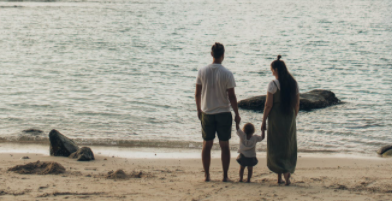

Thank you for your checking this notebook.

This is my notebook for "H&M Personalized Fashion Recommendations" competition [(Link)](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/overview) to predict purchasing articles based on rule base & customer age.

If you think this notebook is interesting, please leave your comment or question and I appreciate your upvote as well. :) 

<a id='top'></a>
## Contents
1. [Import Library & Set Config](#config)
2. [Load Data](#load)
3. [EDA of recent popular articles of each ages](#eda)
4. [Prediction](#pred)
5. [Submission](#sub)
6. [Conclution](#conclution)
7. [Reference](#ref)

<a id='config'></a>

---
## 1. Import Library & Set Config
---

[Back to Contents](#top)

In [1]:
# Code highly inspired and modified from https://www.kaggle.com/code/hechtjp/h-m-eda-rule-base-by-customer-age

# === General ===
import sys, warnings, time, os, copy, gc, re, random, pickle, cudf
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
from datetime import datetime, timedelta

In [2]:
DEBUG = False
PATH_INPUT = r'./data/'

<a id='load'></a>

---
## 2. Load Data
---

[Back to Contents](#top)

In [3]:
def display_df(df, head=3):
    print(f'The shape of df is {df.shape}.\n')
    display(df.head(head))

In [4]:
#dfArticles = cudf.read_csv(PATH_INPUT + 'articles.csv', usecols=['article_id', "product_group_name", "perceived_colour_master_name"])
#display_df(dfArticles, head=3)

In [5]:
dfCustomers = cudf.read_csv(PATH_INPUT + 'customers.csv', usecols=['customer_id'])
display_df(dfCustomers, head=3)
dfCustomers = dfCustomers.to_pandas()

The shape of df is (1371980, 1).



customer_id
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...

In [6]:
dfTransactions = cudf.read_csv(PATH_INPUT + 'transactions_train.csv',  
                               usecols=['t_dat', 'customer_id', 'article_id', 'price'],
                               dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string', 'price': 'float'})
dfTransactions['t_dat'] = cudf.to_datetime(dfTransactions['t_dat'])
display_df(dfTransactions, head=3)
dfTransactions = dfTransactions.to_pandas()

The shape of df is (31788324, 4).



t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   

      price  
0  0.050831  
1  0.030492  
2  0.015237

In [7]:
#listBin = [-1, 0.042, 0.132, 0.27, 0.42, 0.60]


In [8]:
gc.collect()

102

<a id='load'></a>

---
## 3. Get Average cost bins
---

[Back to Contents](#top)

In [9]:
dfTransactions['avg_cost'] = dfTransactions.groupby('customer_id')['price'].transform('mean')

In [10]:
dfCustomers = dfCustomers.merge(dfTransactions[['customer_id','avg_cost']], on='customer_id', how='left')
#listBin = [-1, 0.042, 0.132, 0.27, 0.42, 0.60]
dfCustomers= dfCustomers.groupby(['customer_id'])['avg_cost'].first().reset_index()
dfCustomers['cost_bins'], listBin = pd.qcut(dfCustomers['avg_cost'], 10, retbins=True)
display_df(dfCustomers, head=3)
#dfTransactions.drop_duplicates(subset=['customer_id', 'article_id'], keep='last')

The shape of df is (1371980, 3).



customer_id  avg_cost  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  0.030904   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  0.030255   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.039154   

          cost_bins  
0  (0.0286, 0.0313]  
1  (0.0286, 0.0313]  
2  (0.0348, 0.0424]

In [11]:
listUniBins1 = dfCustomers['cost_bins'].unique().tolist()
print(listUniBins1)
s = 0. 
for uniBin in listUniBins1:
    if str(uniBin) == 'nan':
        dfCustomerstemp = dfCustomers[dfCustomers['cost_bins'].isnull()]
    else:
        dfCustomerstemp = dfCustomers[dfCustomers['cost_bins'] == uniBin]
    print(uniBin)
    print(len(dfCustomerstemp))
    s+=len(dfCustomerstemp)
print("total", s)

[Interval(0.0286, 0.0313, closed='right'), Interval(0.0348, 0.0424, closed='right'), Interval(0.0313, 0.0348, closed='right'), Interval(0.0261, 0.0286, closed='right'), Interval(0.0164, 0.0196, closed='right'), Interval(-0.00023700000000000001, 0.0164, closed='right'), Interval(0.0242, 0.0261, closed='right'), Interval(0.0196, 0.022, closed='right'), Interval(0.022, 0.0242, closed='right'), Interval(0.0424, 0.507, closed='right'), nan]
(0.0286, 0.0313]
136431
(0.0348, 0.0424]
141447
(0.0313, 0.0348]
136025
(0.0261, 0.0286]
136013
(0.0164, 0.0196]
135750
(-0.00023700000000000001, 0.0164]
136707
(0.0242, 0.0261]
136441
(0.0196, 0.022]
137229
(0.022, 0.0242]
135229
(0.0424, 0.507]
131009
nan
9699
total 1371980.0


In [12]:
#dfTransactions['cost_bins'] = pd.cut(dfTransactions['avg_cost'], listBin)
dfTransactions = dfTransactions.merge(dfCustomers[['customer_id','cost_bins']], on='customer_id', how='left')
dfTransactions.set_index('t_dat', inplace=True)

display_df(dfTransactions, head=3)



The shape of df is (31788324, 5).



customer_id  article_id  \
t_dat                                                                       
2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   

               price  avg_cost         cost_bins  
t_dat                                             
2018-09-20  0.050831  0.039154  (0.0348, 0.0424]  
2018-09-20  0.030492  0.039154  (0.0348, 0.0424]  
2018-09-20  0.015237  0.031863  (0.0313, 0.0348]

In [13]:
x = dfTransactions[dfTransactions['cost_bins'].isnull()].shape[0]
print(f'{x} transaction do not have cost information.\n')

0 transaction do not have cost information.



In [14]:
dfRecent = dfTransactions.loc['2020-09-01' : '2020-09-21']
del dfTransactions
gc.collect()
display_df(dfRecent, head=3)

The shape of df is (765403, 5).



customer_id  article_id  \
t_dat                                                                       
2020-09-01  0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...   777148006   
2020-09-01  0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...   835801001   
2020-09-01  0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...   923134005   

               price  avg_cost         cost_bins  
t_dat                                             
2020-09-01  0.013542  0.037506  (0.0348, 0.0424]  
2020-09-01  0.018627  0.037506  (0.0348, 0.0424]  
2020-09-01  0.012695  0.037506  (0.0348, 0.0424]

In [15]:
listUniBins = dfRecent['cost_bins'].unique().tolist()

print(listUniBins)
s = 0. 
for uniBin in listUniBins:
    if str(uniBin) == 'nan':
        dfRecenttemp = dfRecent[dfRecent['cost_bins'].isnull()]
    else:
        dfRecenttemp = dfRecent[dfRecent['cost_bins'] == uniBin]
    print(uniBin)
    print(len(dfRecenttemp))
    s+=len(dfRecenttemp)

[Interval(0.0348, 0.0424, closed='right'), Interval(0.0313, 0.0348, closed='right'), Interval(0.0164, 0.0196, closed='right'), Interval(0.0242, 0.0261, closed='right'), Interval(0.0261, 0.0286, closed='right'), Interval(0.0286, 0.0313, closed='right'), Interval(0.0424, 0.507, closed='right'), Interval(0.0196, 0.022, closed='right'), Interval(0.022, 0.0242, closed='right'), Interval(-0.00023700000000000001, 0.0164, closed='right')]
(0.0348, 0.0424]
108582
(0.0313, 0.0348]
104076
(0.0164, 0.0196]
45630
(0.0242, 0.0261]
80486
(0.0261, 0.0286]
102843
(0.0286, 0.0313]
109299
(0.0424, 0.507]
51516
(0.0196, 0.022]
61295
(0.022, 0.0242]
76828
(-0.00023700000000000001, 0.0164]
24848


In [16]:
#dfRecent = dfRecent.to_pandas()
#dfRecent = dfRecent.merge(dfCu|stomers[['customer_id', 'age_bins']], on='customer_id', how='inner')
dfRecent = dfRecent.drop(['price'], axis=1).reset_index()
dfRecent = dfRecent.drop(['t_dat'], axis=1)
dfRecent = dfRecent.drop(['avg_cost'], axis=1)
display_df(dfRecent, head=3)

The shape of df is (765403, 3).



customer_id  article_id  \
0  0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...   777148006   
1  0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...   835801001   
2  0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...   923134005   

          cost_bins  
0  (0.0348, 0.0424]  
1  (0.0348, 0.0424]  
2  (0.0348, 0.0424]

In [17]:
pd.Series(dfRecent['article_id']).is_unique
dfRecent = dfRecent.groupby(['cost_bins', 'article_id']).count().reset_index().rename(columns={'customer_id': 'counts'})
display_df(dfRecent, head=20)

The shape of df is (259900, 3).



cost_bins  article_id  counts
0   (-0.00023700000000000001, 0.0164]   108775044       4
1   (-0.00023700000000000001, 0.0164]   110065011       1
2   (-0.00023700000000000001, 0.0164]   111565001      12
3   (-0.00023700000000000001, 0.0164]   111586001      31
4   (-0.00023700000000000001, 0.0164]   111593001      26
5   (-0.00023700000000000001, 0.0164]   111609001      12
6   (-0.00023700000000000001, 0.0164]   120129001       0
7   (-0.00023700000000000001, 0.0164]   120129014       1
8   (-0.00023700000000000001, 0.0164]   123173001      39
9   (-0.00023700000000000001, 0.0164]   126589007       1
10  (-0.00023700000000000001, 0.0164]   126589010       0
11  (-0.00023700000000000001, 0.0164]   129085001       3
12  (-0.00023700000000000001, 0.0164]   129085026       0
13  (-0.00023700000000000001, 0.0164]   129085027       0
14  (-0.00023700000000000001, 0.0164]   130035001       2
15  (-0.00023700000000000001, 0.0164]   144993001       2
16  (-0.00023700000000000001, 0.0164]   145872001       0
17  (-0.00023700000000000001, 0.0164]   145872037       0
18  (-0.00023700000000000001, 0.0164]   145872052       0
19  (-0.00023700000000000001, 0.0164]   145872053       0

In [18]:

    
print("total", s)

dict100 = {}
for uniBin in listUniBins:
    dfTemp = dfRecent[dfRecent['cost_bins'] == uniBin]
    dfTemp = dfTemp.sort_values(by='counts', ascending=False)
    dict100[uniBin] = dfTemp.head(100)['article_id'].values.tolist()

df100 = pd.DataFrame([dict100]).T.rename(columns={0:'top100'})


total 765403.0


<AxesSubplot:>

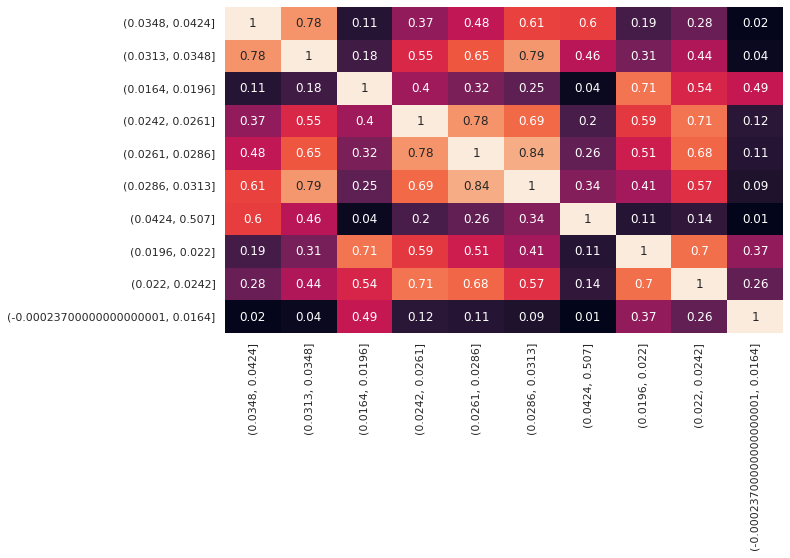

In [19]:
for index in df100.index:
    df100[index] = [len(set(df100.at[index, 'top100']) & set(df100.at[x, 'top100']))/100 for x in df100.index]

df100 = df100.drop(columns='top100')
plt.figure(figsize=(10, 6))
sns.heatmap(df100, annot=True, cbar=False)

<a id='pred'></a>

---
## 4. Prediction

- Predict articles for each age and save the results as csv file separately.
- Prediction is done by the rule base learned from the notebook [H&M: Faster Trending Products Weekly by Mr. HERVIND PHILIPE](https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook). (Please check and upvote it.)

---

[Back to Contents](#top)

In [20]:
N= 12
listUniBins = dfRecent['cost_bins'].unique().tolist()
print(listUniBins)

[Interval(-0.00023700000000000001, 0.0164, closed='right'), Interval(0.0164, 0.0196, closed='right'), Interval(0.0196, 0.022, closed='right'), Interval(0.022, 0.0242, closed='right'), Interval(0.0242, 0.0261, closed='right'), Interval(0.0261, 0.0286, closed='right'), Interval(0.0286, 0.0313, closed='right'), Interval(0.0313, 0.0348, closed='right'), Interval(0.0348, 0.0424, closed='right'), Interval(0.0424, 0.507, closed='right')]


In [21]:
'''for uniBin in listUniBins:
    if str(uniBin) == 'nan':
        dfCustomersTemp = dfCustomers[dfCustomers['cost_bins'].isnull()]
    else:
        dfCustomersTemp = dfCustomers[dfCustomers['cost_bins'] == uniBin]
    print(uniBin)
    print(len(dfCustomersTemp))'''

"for uniBin in listUniBins:\n    if str(uniBin) == 'nan':\n        dfCustomersTemp = dfCustomers[dfCustomers['cost_bins'].isnull()]\n    else:\n        dfCustomersTemp = dfCustomers[dfCustomers['cost_bins'] == uniBin]\n    print(uniBin)\n    print(len(dfCustomersTemp))"

In [22]:
gc.collect()

63

In [23]:
for uniBin in listUniBins:
    df_train  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',
                            usecols= ['t_dat', 'customer_id', 'article_id'], 
                            dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
    #df_train['t_dat'] = cudf.to_datetime(df_train['t_dat'])
    #df_train.set_index('t_dat', inplace=True)
    df = df_train
    #df = df.reset_index()
    del df_train
    if str(uniBin) == 'nan':
        dfCustomersTemp = dfCustomers[dfCustomers['cost_bins'].isnull()]
    else:
        dfCustomersTemp = dfCustomers[dfCustomers['cost_bins'] == uniBin]
    if len(dfCustomersTemp) ==0:
        continue
    dfCustomersTemp = dfCustomersTemp.drop(['cost_bins'], axis=1)
    dfCustomersTemp = cudf.from_pandas(dfCustomersTemp)
    
    df = df.merge(dfCustomersTemp[['customer_id', 'avg_cost']], on='customer_id', how='inner')
    print(f'The shape of scope transaction for {uniBin} is {df.shape}. \n')
          
    df ['customer_id'] = df ['customer_id'].str[-16:].str.hex_to_int().astype('int64')
    df['t_dat'] = cudf.to_datetime(df['t_dat'])
    last_ts = df['t_dat'].max()

    tmp = df[['t_dat']].copy().to_pandas()
    tmp['dow'] = tmp['t_dat'].dt.dayofweek
    tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
    tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

    df['ldbw'] = tmp['ldbw'].values
    
    weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
    weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
    
    df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
    
    weekly_sales = weekly_sales.reset_index().set_index('article_id')

    df = df.merge(
        weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
        on='article_id', suffixes=("", "_targ"))

    df['count_targ'].fillna(0, inplace=True)
    del weekly_sales
    gc.collect()
    
    df['quotient'] = df['count_targ'] / df['count']
    
    target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
    general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
    general_pred = ['0' + str(article_id) for article_id in general_pred]
    general_pred_str =  ' '.join(general_pred)
    del target_sales
    gc.collect()
    
    purchase_dict = {}

    tmp = df.copy().to_pandas()
    tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
    tmp['dummy_1'] = 1 
    tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d

    tmp['dummy_0'] = 0 
    tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
    tmp['value'] = tmp['quotient'] * tmp['y'] 

    tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
    tmp = tmp.reset_index()

    tmp = tmp.loc[tmp['value'] > 0]
    tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
    tmp = tmp.loc[tmp['rank'] <= 12]

    purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
    purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
    purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    purchase_df = cudf.DataFrame(purchase_df)
    
    sub  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})
    
    numCustomers = sub.shape[0]
    
    sub = sub.merge(dfCustomersTemp[['customer_id', 'avg_cost']], on='customer_id', how='inner')

    sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

    sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
                   suffixes = ('', '_ignored'))

    sub = sub.to_pandas()
    sub['prediction'] = sub['prediction'].fillna(general_pred_str)
    sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
    sub['prediction'] = sub['prediction'].str.strip()
    sub['prediction'] = sub['prediction'].str[:131]
    sub = sub[['customer_id', 'prediction']]
    sub.to_csv(f'submission_' + str(uniBin) + '.csv',index=False)
    print(f'Saved prediction for {uniBin}. The shape is {sub.shape}. \n')
    print('-'*50)
    del sub
    gc.collect()
print('Finished.\n')
print('='*50)

The shape of scope transaction for (-0.00023700000000000001, 0.0164] is (1539609, 4). 

Saved prediction for (-0.00023700000000000001, 0.0164]. The shape is (136707, 2). 

--------------------------------------------------
The shape of scope transaction for (0.0164, 0.0196] is (2487756, 4). 

Saved prediction for (0.0164, 0.0196]. The shape is (135750, 2). 

--------------------------------------------------
The shape of scope transaction for (0.0196, 0.022] is (3134804, 4). 

Saved prediction for (0.0196, 0.022]. The shape is (137229, 2). 

--------------------------------------------------
The shape of scope transaction for (0.022, 0.0242] is (3655515, 4). 

Saved prediction for (0.022, 0.0242]. The shape is (135229, 2). 

--------------------------------------------------
The shape of scope transaction for (0.0242, 0.0261] is (3625975, 4). 

Saved prediction for (0.0242, 0.0261]. The shape is (136441, 2). 

--------------------------------------------------
The shape of scope transa

In [24]:
dfCheck = cudf.read_csv('../input/submissions-age/submissions_age.csv')
nans_series = dfCustomers.loc[dfCustomers['cost_bins'].isnull(), 'customer_id']
#print(nans_series)

nans_series = nans_series.to_list()
#print(nans_series)

display_df(dfCheck, head=3)
dfCheck = dfCheck[dfCheck['customer_id'].isin(nans_series)]
display_df(dfCheck, head=3)

The shape of df is (1371980, 2).



customer_id  \
0  2970df42f8d0c5feb4755452e2abeadf54839adf2c1e91...   
1  290655cdef03b9f6f2cc92499f9883648543a62a95af25...   
2  284f57474732a822d814c276a354ac2fc1ca92b6ac0819...   

                                          prediction  
0  0837283001 0818397001 0373506001 0179123001 07...  
1  0785018003 0781758001 0918591001 0695632107 08...  
2  0804996007 0730683050 0805011013 0599718001 07...

The shape of df is (9699, 2).



customer_id  \
218  2d7580568f58795d9b6e20954629595c239a4165ccff2c...   
720  1e3d666228ca4d1939bc2c7c46f48a03445bbf5ae2c810...   
734  1d45a02bde074325486b4aa0c1f5e4e8db67e47b7ad104...   

                                            prediction  
218  0751471001 0448509014 0579541001 0706016001 06...  
720  0751471001 0448509014 0579541001 0706016001 06...  
734  0751471001 0448509014 0579541001 0706016001 06...

<a id='sub'></a>

---
## 5. Submission

- Load the saved prediction csv files and concatenate them in one dataframe.
- Save it as submission.csv.

---

[Back to Contents](#top)

In [25]:
for i, uniBin in enumerate(listUniBins):
    dfTemp  = cudf.read_csv(f'submission_' + str(uniBin) + '.csv')
    if i == 0:
        dfSub = dfTemp
    else:
        dfSub = cudf.concat([dfSub, dfTemp], axis=0)
dfSub = cudf.concat([dfSub, dfCheck], axis=0)
assert dfSub.shape[0] == numCustomers, f'The number of dfSub rows is not correct. {dfSub.shape[0]} vs {numCustomers}.'

dfSub.to_csv(f'submission.csv', index=False)
print(f'Saved submission.csv.')



Saved submission.csv.


In [26]:
dfCheck = cudf.read_csv('./submission.csv')
display_df(dfCheck, head=3)

The shape of df is (1371980, 2).



customer_id  \
0  2adad230479973411b5a28f919e0b0362067666a5b17cd...   
1  2c3ba567fbb4b8cd6bfcf547774eb4ff3d7a7a9ea8dcb3...   
2  2942623282a2dc10767eb14f1cf5cf0fdb091dea461a64...   

                                          prediction  
0  0448509014 0666392018 0775081002 0759871003 07...  
1  0507883014 0610776002 0711053003 0156231001 03...  
2  0784644001 0610776065 0610776002 0469039019 07...

<a id='conclution'></a>

---

## 6. Conclution

Thank you for your reading through this Notebook!

The score on LB. is 0.0227 which is 0.0005 improved than the case which does not consider customer's age :)

If you think this notebook is interesting for you, please do click upvote :)

---

[Back to Contents](#top)

<a id='ref'></a>

---
## 7. Reference

1.  [H&M: Faster Trending Products Weekly by Mr. HERVIND PHILIPE](https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook)

---

[Back to Contents](#top)